In [54]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import time
import os
import glob
from itertools import combinations
import copy
import backbone as backbone
import configs
from data.datamgr import SimpleDataManager, SetDataManager
from methods.baselinetrain import BaselineTrain
from methods.gnnnet import GnnNet
from methods.baselinefinetune import BaselineFinetune
from methods.protonet import ProtoNet
from methods import damsl_v1
from methods import damsl_v1_proto
from methods import damsl_v2
from methods import damsl_v2_gnn
from methods import damsl_v2_proto
from methods.protonet import euclidean_dist

configs.save_dir = 'logs_final_train' ##override
from io_utils import model_dict, parse_args, get_resume_file, get_best_file, get_assigned_file 

from utils import *

from datasets import ISIC_few_shot, EuroSAT_few_shot, CropDisease_few_shot, Chest_few_shot, miniImageNet_few_shot, DTD_few_shot, CUB_few_shot, cifar_few_shot, caltech256_few_shot, cars_few_shot, plantae_few_shot, places_few_shot

class Classifier(nn.Module):
    def __init__(self, dim, n_way):
        super(Classifier, self).__init__()
        
        self.fc = nn.Linear(dim, n_way)

    def forward(self, x):
        x = self.fc(x)
        return x

def finetune_classify(liz_x,y, model, state_in, save_it, linear = False, flatten = True, n_query = 15, ds= False, pretrained_dataset='miniImageNet', freeze_backbone = False, n_way = 5, n_support = 5): 
    ###############################################################################################
    # load pretrained model on miniImageNet
    if "damsl_v1" in params.method or params.method == "gnnnet":
      pretrained_model = model_dict[params.model](flatten = flatten)
      state_temp = copy.deepcopy(state_in)
      state_keys = list(state_temp.keys())
      for _, key in enumerate(state_keys):
          if "feature." in key:
              newkey = key.replace("feature.","")  # an architecture model has attribute 'feature', load architecture feature to backbone by casting name from 'feature.trunk.xx' to 'trunk.xx'  
              state_temp[newkey] = state_temp.pop(key)
          else:
              state_temp.pop(key)
      pretrained_model.load_state_dict(state_temp)
    else:
      pretrained_model = copy.deepcopy(model.feature_baseline2)
    
    
    model = model.to(device)
    model.train()
    
    ###############################################################################################

    classifier = Classifier(model.feature_baseline.final_feat_dim, model.n_way)

    ###############################################################################################
    
    x = liz_x[0] ### non-changed one
    #print(x.shape)
    #print(n_query)
    model.n_query = n_query
    #x = x
    x_var = Variable(x)
    
    support_size = n_way * n_support 
    batch_size = 8

    y_a_i = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) )).to(device) # (25,)

    x_b_i = x_var[:, n_support:,:,:,:].contiguous().view( n_way* n_query,   *x.size()[2:]).to(device)
    x_a_i = x_var[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:]) # (25, 3, 224, 224)
    x_a_i_original = copy.deepcopy(x_a_i.to(device))
    x_inn = x_var.view(n_way* (n_support + n_query), *x.size()[2:]).to(device)
    
    ### to load all the changed examples

    x_a_i = torch.cat((x_a_i, x_a_i), dim = 0) ##oversample the first one
    y_a_i = torch.cat((y_a_i, y_a_i), dim = 0)
    for x_aug in liz_x[1:]:
      #x_aug = x_aug
      x_aug = Variable(x_aug)
      x_a_aug = x_aug[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:])
      y_a_aug = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) )).to(device)
      x_a_i = torch.cat((x_a_i, x_a_aug), dim = 0)
      y_a_i = torch.cat((y_a_i, y_a_aug.to(device)), dim = 0)
    
    ###############################################################################################
    
    #optimizer = torch.optim.Adam(model.parameters())
    names = []
    for name, param in pretrained_model.named_parameters():
      if param.requires_grad:
        #print(name)
        names.append(name)
    
    names_sub = names[:-9] ### last Resnet block can adapt

    for name, param in pretrained_model.named_parameters():
      if name in names_sub:
        param.requires_grad = False

    if freeze_backbone is False:
        delta_opt = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr = 0.01)

    loss_fn = nn.CrossEntropyLoss().to(device) ##change this code up ## dorop n way
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr = 0.01) ##try it with weight_decay
    pretrained_model.to(device)
    classifier.to(device)
    ###############################################################################################
    total_epoch = params.fine_tune_epoch

    if freeze_backbone is False:
        pretrained_model.train()
    
    #pretrained_model_fixed = copy.deepcopy(pretrained_model)
    #pretrained_model_fixed.eval()
    classifier.train()
    lengt = len(liz_x) +1
    for epoch in range(total_epoch):
        rand_id = np.random.permutation(support_size * lengt)

        for j in range(0, support_size * lengt, batch_size):
            classifier_opt.zero_grad()
            if freeze_backbone is False:
                delta_opt.zero_grad()

            #####################################
            selected_id = torch.from_numpy( rand_id[j: min(j+batch_size, support_size * lengt)]).to(device)
            
            z_batch = x_a_i[selected_id].to(device)
            y_batch = y_a_i[selected_id] 
            #####################################

            output = pretrained_model(z_batch)
            if flatten == False:
              avgpool = nn.AvgPool2d(7)
              flat = backbone.Flatten()
              output = flat(avgpool(output))
            scores  = classifier(output)
            loss = loss_fn(scores, y_batch)

            #####################################
            loss.backward()

            classifier_opt.step()
            
            if freeze_backbone is False:
                delta_opt.step()

    
    #output_support = pretrained_model(x_a_i_original.to(device)).view(n_way, n_support, -1)
    #output_query = pretrained_model(x_b_i.to(device)).view(n_way,n_support+n_query,-1)

  


    output_all = pretrained_model(x_inn.to(device)).view(n_way, n_support + n_query, -1).detach()
    if params.method == "damsl_v1" or params.method == "damsl_v2" :
      final = classifier(output_all)
      batchnorm = model.batchnorm
      final = torch.transpose(batchnorm(torch.transpose(final, 1,2)),1,2).contiguous()
      z = model.fc2(final.view(-1, *final.size()[2:]))
      z = z.view(model.n_way, -1, z.size(1))

      print("hello")
    elif params.method == "damsl_v2_gnn":
      z = model.fc2(output_all.view(-1, *output_all.size()[2:]))
      z = z.view(model.n_way, -1, z.size(1))
    elif params.method == "damsl_v2_proto":
      final = classifier(output_all)
      final = torch.transpose(model.batchnorm(torch.transpose(final, 1,2)),1,2).contiguous()
      #z = model.fc_deep(final.view(-1, *final.size()[2:])) ## use fc deep for deep embedding network
      #z = z.view(model.n_way, -1, z.size(1))

    output_all_l = pretrained_model(x_b_i.to(device)).detach()
    final_l = classifier(output_all_l)
    final_l = torch.nn.functional.softmax(final_l, dim = 1).detach()

    output_all_l_2 = pretrained_model(x_a_i_original.to(device)).detach()
    final_l_2 = classifier(output_all_l_2)
    final_l_2 = torch.nn.functional.softmax(final_l_2, dim = 1).detach()
   
    

    if "sbmtl" or "damsl" in params.method:
        #### copy baseline feature and instantiate classifer
        baseline_feat = copy.deepcopy(model.feature_baseline)
        classifier_baseline = Classifier(model.feature_baseline.final_feat_dim, model.n_way) ##instantiate classifier
        classifier_baseline.to(device)
    
        ### freeze layers of baseline feat
        names_b = []
        for name, param in baseline_feat.named_parameters():
            if param.requires_grad:
                #print(name)
                names.append(name)
        
        names_sub_b = names_b[:-9] ### last Resnet block can adapt

        for name, param in baseline_feat.named_parameters():
            if name in names_sub_b:
                param.requires_grad = False   

        delta_opt_b = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline_feat.parameters()), lr = 0.01)
        classifier_opt_b = torch.optim.Adam(classifier_baseline.parameters(), lr = 0.01)

        for epoch in range(total_epoch):
            rand_id = np.random.permutation(support_size * lengt)

            for j in range(0, support_size * lengt, batch_size):
                classifier_opt_b.zero_grad()
                
                delta_opt_b.zero_grad()

                #####################################
                selected_id = torch.from_numpy( rand_id[j: min(j+batch_size, support_size * lengt)]).to(device)
                z_batch = x_a_i[selected_id].to(device)
                y_batch = y_a_i[selected_id] 
                #####################################

                output = baseline_feat(z_batch)
                score  = classifier_baseline(output)
                loss_b = loss_fn(score, y_batch)
                #grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True)

                #####################################
                loss_b.backward() ### think about how to compute gradients and achieve a good initialization

                classifier_opt_b.step()
                delta_opt_b.step()
        
        #output_support_b = baseline_feat(x_a_i_original.to(device)).view(n_way, n_support, -1)
        #output_query_b = baseline_feat(x_b_i.to(device)).view(n_way,n_query,-1)

      

        output_all_b = baseline_feat(x_inn.to(device)).view(n_way, n_support + n_query, -1).detach()
        if params.method == "damsl_v1" or params.method == "damsl_v2" :
          final_b = classifier_baseline(output_all_b).detach() ##initial baseline scores
          final_b = torch.transpose(model.batchnorm2(torch.transpose(final_b, 1,2)),1,2).contiguous()
          z_b = model.fc2(final_b.view(-1, *final_b.size()[2:]))
          z_b = z_b.view(model.n_way, -1, z_b.size(1))
        elif params.method == "damsl_v2_gnn":
          z_b = model.fc2(output_all_b.view(-1, *output_all_b.size()[2:]))
          z_b = z_b.view(n_way, -1, z_b.size(1))
        elif params.method == "damsl_v2_proto":
          final_b = classifier_baseline(output_all_b).detach()
          final_b = torch.transpose(model.batchnorm2(torch.transpose(final_b, 1,2)),1,2).contiguous()
          #z_b = model.fc_deep(final_b.view(-1, *final_b.size()[2:]))
          #z_b = z_b.view(n_way, -1, z_b.size(1))

          #z = torch.cat([z, z_b], dim = 2)

          final = torch.cat([final, final_b], dim = 2)
          z = model.fc_deep(final.view(-1, *final.size()[2:])) ## use fc deep for deep embedding network
          z = z.view(n_way, -1, z.size(1))
  
          z_support = z[:,:model.n_support,:].contiguous()
          z_query = z[:,model.n_support:,:].contiguous()
          
          z_proto     = z_support.view(model.n_way, model.n_support, -1 ).mean(1) #the shape of z is [n_data, n_dim]
          z_query     = z_query.contiguous().view(model.n_way* model.n_query, -1 )

          dists = euclidean_dist(z_query, z_proto)
          scores = -dists
          return scores ## early return

        
        #final = torch.cat([final, final_b], dim = 2)
        
        
        output_all_b_l = baseline_feat(x_b_i.to(device)).detach()
        final_b_l = classifier_baseline(output_all_b_l).detach() ##initial baseline scores
        final_b_l = torch.nn.functional.softmax(final_b_l, dim = 1).detach()

        
        output_all_b_l_2 = baseline_feat(x_a_i_original.to(device)).detach()
        final_b_l_2 = classifier_baseline(output_all_b_l_2).detach() ##initial baseline scores
        final_b_l_2 = torch.nn.functional.softmax(final_b_l_2, dim = 1).detach()
        
  
        z = torch.cat([z, z_b], dim = 2)
        #
        #z = model.fc_new(final.view(-1, *final.size()[2:]))
        #z = z.view(model.n_way, -1, z.size(1))
    else:
        z = model.fc2(final.view(-1, *final.size()[2:]))
        z = z.view(model.n_way, -1, z.size(1))
        #z = torch.cat([z, z_b], dim = 2) ##concatenate

    z_stack = [torch.cat([z[:, :model.n_support], z[:, model.n_support + i:model.n_support + i + 1]], dim=1).view(1, -1, z.size(2)) for i in range(n_query)]

    score = model.forward_gnn(z_stack)
    score = torch.nn.functional.softmax(score, dim = 1).detach()

    return score, final_l + final_b_l, final_l_2 + final_b_l_2

In [55]:
np.random.seed(10)

##################################################################
image_size = 224
iter_num = 3
n_way  = 5
pretrained_dataset = "miniImageNet"
ds = False

n_way = 5
n_query = 15

few_shot_params = dict(n_way = 5 , n_support = 5) 

datamgr             =  EuroSAT_few_shot.SetDataManager2(image_size, n_eposide = iter_num, n_query = 15, **few_shot_params)
novel_loader        = datamgr.get_data_loader(num_aug = 17)

In [56]:
for idx, (elem) in enumerate(novel_loader):
      leng = len(elem)
      
      assert(torch.all(torch.eq(elem[0][0] , elem[1][0])) )
      _, y = elem[0]
      
      liz_x = [x for (x,y) in elem]

      x = liz_x[0]

      print(x.shape)
      break
      

/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:752: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.Rando

torch.Size([3, 224, 224])
tensor([[[-1.4500, -1.4672, -1.4672,  ..., -1.3987, -1.3987, -1.3987],
         [-1.4672, -1.4843, -1.4843,  ..., -1.3987, -1.3987, -1.3987],
         [-1.4672, -1.4843, -1.4843,  ..., -1.3987, -1.3987, -1.3987],
         ...,
         [-1.3644, -1.3644, -1.3644,  ..., -1.3987, -1.3987, -1.3987],
         [-1.3644, -1.3644, -1.3644,  ..., -1.4158, -1.4158, -1.4158],
         [-1.3644, -1.3644, -1.3644,  ..., -1.3987, -1.3987, -1.3987]],

        [[-0.9153, -0.9153, -0.9153,  ..., -0.8803, -0.8803, -0.8803],
         [-0.9328, -0.9328, -0.9328,  ..., -0.8978, -0.8978, -0.8978],
         [-0.9328, -0.9328, -0.9328,  ..., -0.8978, -0.8978, -0.8978],
         ...,
         [-0.9153, -0.9153, -0.9153,  ..., -0.9328, -0.9328, -0.9503],
         [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9503, -0.9503],
         [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328]],

        [[-0.3753, -0.3927, -0.3927,  ..., -0.3753, -0.3753, -0.3753],
         [-0.3927, 

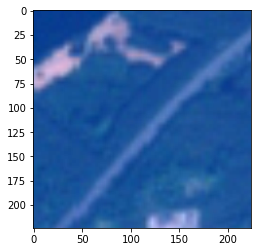

In [57]:
print(x[0][0].shape)

print(x[0][0])

import matplotlib.pyplot as plt
def renormal(a):   
    x_new = (a - a.min())
    x_new = x_new / x_new.max() 
    return x_new

plt.imshow(  renormal(x[1][0]).permute(1, 2, 0)  )

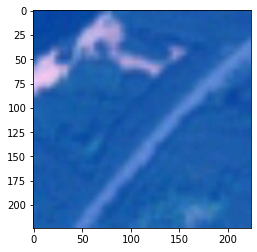

In [58]:
x2 = liz_x[7]

plt.imshow(  renormal(x2[1][0]).permute(1, 2, 0)  )

In [59]:
model           = damsl_v2.GnnNet( model_dict["ResNet10"], **few_shot_params )
checkpoint_dir = "logs_final_train/checkpoints/miniImageNet/ResNet10_damsl_v2_aug_5way_5shot"
modelfile   = get_assigned_file(checkpoint_dir,600)
import json
class Bunch(object):
  def __init__(self, adict):
    self.__dict__.update(adict)

with open('commandline_args.txt', 'r') as f:
   params = Bunch(json.load(f))

params.method = "damsl_v2"
params.checkpoint_dir = checkpoint_dir


if modelfile is not None:
    tmp = torch.load(modelfile)
    state = tmp['state']
    state_keys = list(state.keys())
    for _, key in enumerate(state_keys):
        if "feature2." in key:
            state.pop(key)
        if "feature3." in key:
            state.pop(key)
        if "classifier2." in key:
            classifier_found = True
            state.pop(key)
        if "classifier3." in key:
            classifier_found = True
            state.pop(key)
    model.classifier = Classifier(model.feat_dim, n_way)
    model.batchnorm = nn.BatchNorm1d(5, track_running_stats=False)
    
    model.instantiate_baseline(params)
    model.load_state_dict(state)
    model.to(device)


In [61]:
for idx, (elem) in enumerate(novel_loader):
      leng = len(elem)
      
      assert(torch.all(torch.eq(elem[0][0] , elem[1][0])) )
      _, y = elem[0]
      
      liz_x = [x for (x,y) in elem]

      scores, linear_scores, linear_scores_2 = finetune_classify(liz_x,y, model, state, ds = ds, save_it = 600, n_query = 15, pretrained_dataset=pretrained_dataset, freeze_backbone=False, **few_shot_params)

      x = liz_x[0]

      break

/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:752: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.Rando

In [ ]:
### print out some stuff
print(scores.shape)
print(linear_scores.shape)

#print(scores2.shape)
#print(linear_scores_2.shape)
##scores2 = scores2.cpu()

#scores2 = scores2.reshape(5,15,5)[:,:5,:].reshape(25,5)



In [78]:
print(torch.argmax(scores, dim = 1))
print(torch.argmax(linear_scores, dim = 1))


def acc(sco):
    y_query = np.repeat(range(n_way ), n_query )

    topk_scores, topk_labels = sco.data.topk(1, 1, True, True)
    topk_ind = topk_labels.cpu().numpy()

    top1_correct = np.sum(topk_ind[:,0] == y_query)
    
    
    correct_this, count_this = float(top1_correct), len(y_query)


    return correct_this/ count_this * 100, topk_ind[:,0] == y_query

acc_scores, sc_q = acc(scores)
scc_linear_scores, lc_q = acc(linear_scores)


corrected = [i for i,(x,y) in enumerate(zip(sc_q,lc_q)) if x and not y]

made_wrong = [i for i, (x,y) in enumerate(zip(sc_q,lc_q)) if not x and y]

always_wrong = [i for i, (x,y) in enumerate(zip(sc_q,lc_q)) if not x and not y]


print(corrected)
print(made_wrong)
print(always_wrong)
set_corr = set(corrected)
corrected_list = [1 if i in set_corr else 0 for i in range(n_query*n_way)]  
print(corrected_list)

ls_corrected = np.asarray([s for s,boo in zip(linear_scores.cpu().numpy(), corrected_list) if boo == 1])
print(ls_corrected)
gt_lab = [s for boo,s in zip(corrected_list,np.repeat(range(n_way ), n_query )) if boo == 1]

print(gt_lab)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4], device='cuda:3')
tensor([0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 4,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4], device='cuda:3')
[2, 7, 10, 14, 22, 26, 47]
[]
[27, 42]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[9.2979896e-01 1.2199600e-03 6.2865077e-04 3.2762803e-02 1.0355896e+00]
 [9.0720914e-02 5.5492830e-05 1.8197101e+00 6.2069215e-04 8.8892721e-02]
 [2.3371492e-02 2.8883417e-06 1.9752438

In [82]:
import numpy as np
from sklearn.manifold import TSNE

scores_np = scores.cpu().numpy()

#scores2_np = scores2.cpu().numpy()

linear_scores_np = ls_corrected
linear_scores2_np = linear_scores_2.cpu().numpy()

lin_sc = linear_scores_np
sc = scores_np
lin_sc = np.concatenate((linear_scores_np, linear_scores2_np))

#sc = np.concatenate((scores_np, scores2_np))

ls_embedded =  TSNE(n_components=2).fit_transform(linear_scores2_np)

sc_embedded = TSNE(n_components=2).fit_transform(sc)

print(ls_embedded.shape)


(25, 2)


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

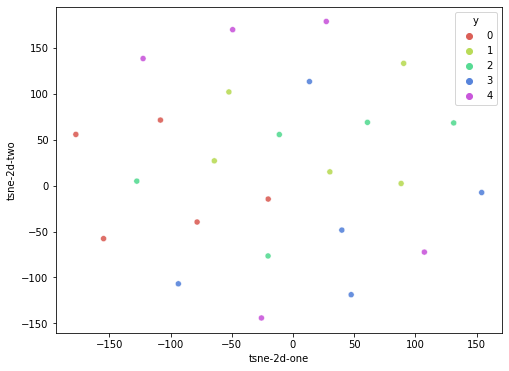

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd


df_subset = pd.DataFrame({'tsne-2d-one':ls_embedded[:,0], 'tsne-2d-two': ls_embedded[:,1], "y" : list(np.repeat(range(n_way ), 5 ))})

#df_subset = pd.DataFrame({'tsne-2d-one':ls_embedded[:,0], 'tsne-2d-two': ls_embedded[:,1], "y" : list(np.repeat(range(n_way ), n_query )), "style": corrected_list})

#df_subset = pd.DataFrame({'tsne-2d-one':ls_embedded[:,0], 'tsne-2d-two': ls_embedded[:,1], "y" :  gt_lab + list(np.repeat(range(n_way ), 5 )), "style": [0] * len(ls_corrected) + [1] * 25  })



plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    #style = "style",
    data=df_subset,
    legend="full",
    alpha=0.9
)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

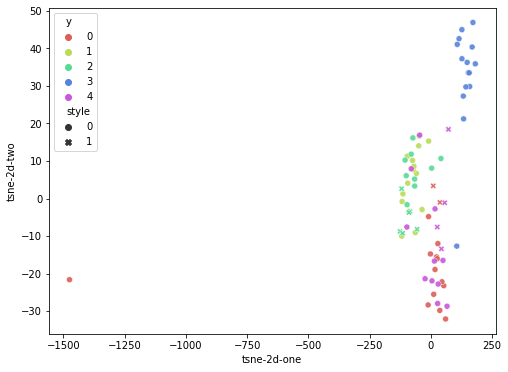

In [44]:
import matplotlib.pyplot as plt

import pandas as pd


df_subset = pd.DataFrame({'tsne-2d-one':sc_embedded[:,0], 'tsne-2d-two': ls_embedded[:,1], "y" : list(np.repeat(range(n_way), n_query )),  "style": corrected_list})



plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    style = "style",
    data=df_subset,
    legend="full",
    alpha=0.9
)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

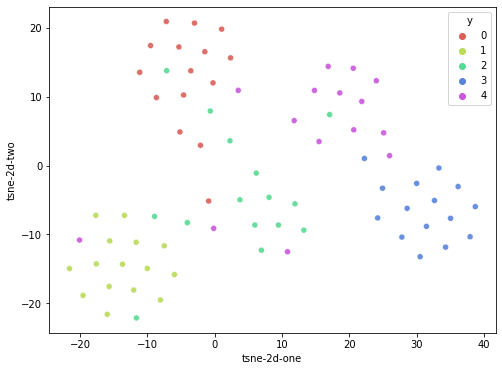

In [98]:
ls_embedded =  TSNE(n_components=2).fit_transform(linear_scores_np)

sc_embedded = TSNE(n_components=2).fit_transform(scores_np)


import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd


df_subset = pd.DataFrame({'tsne-2d-one':ls_embedded[:,0], 'tsne-2d-two': ls_embedded[:,1], "y" : list(np.repeat(range(n_way ), n_query )) , "style": [0] * 75 })



plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=df_subset,
    legend="full",
    alpha=0.9
)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

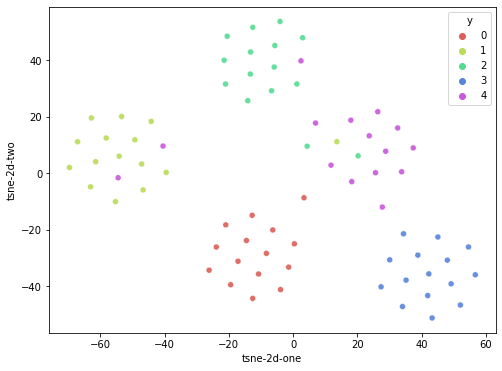

In [99]:
df_subset = pd.DataFrame({'tsne-2d-one':sc_embedded[:,0], 'tsne-2d-two': sc_embedded[:,1], "y" : list(np.repeat(range(n_way ), n_query )) , "style": [0] * 75 })



plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=df_subset,
    legend="full",
    alpha=0.9
)